# Libraries

In [9]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go


In [10]:


import numpy as np
from numpy import linalg as LA
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
import matplotlib.pyplot as plt

class Configuration:
    """Generate a configuration of spins on a Kagome lattice"""
    
    def __init__(self, a, theta, Nx, Ny, J, T):
        self.a, self.theta, self.Nx, self.Ny, self.J, self.T = a, theta, Nx, Ny, J, T
        self.N = Nx * Ny

        # Lattice translation vectors
        a_1 = a * np.array([1, 0])
        a_2 = a * np.array([-np.cos(theta), np.sin(theta)])

        # Unit cell: three spins
        unit_cell = np.array([[0, 0], 0.5 * a_2, 0.5 * a_1])

        # Grid points
        self.x_l, self.y_l = np.meshgrid(np.arange(Nx), np.arange(Ny))
        A_1 = np.tensordot(self.y_l, np.ones(3)[:, None] * a_1, axes=0)
        A_2 = np.tensordot(self.x_l, np.ones(3)[:, None] * a_2, axes=0)

        # Lattice points
        self.lattice = A_1 + A_2 + unit_cell[None, None, :, :]

        # Spin configuration (Nx, Ny, 3 spins, 3 components)
        np.random.seed(50)
        config = 2 * np.random.rand(Nx, Ny, 3, 3) - 1
        norm = np.linalg.norm(config, axis=-1, keepdims=True)
        self.config = config / norm

    def get_energy(self, i, j, s):
        """Energy contribution of a spin with nearest neighbors"""
        S = self.config[i, j, s, :]

        # Nearest neighbor indices with periodic boundary conditions
        kernel = np.mod(
            np.array([[[i, j - 1, 1], [i - 1, j, 2]],
                      [[i - 1, j + 1, 2], [i, j + 1, 0]],
                      [[i + 1, j - 1, 1], [i + 1, j, 0]]]),
            [self.Nx, self.Ny, 3]
        )

        S_nearest = self.config[i, j, (s + 1) % 3, :] + self.config[i, j, (s + 2) % 3, :]
        S_nearest += self.config[kernel[s, 0, 0], kernel[s, 0, 1], kernel[s, 0, 2], :]
        S_nearest += self.config[kernel[s, 1, 0], kernel[s, 1, 1], kernel[s, 1, 2], :]

        E = self.J * np.dot(S, S_nearest)
        return E

    def total_energy(self):
        """Total energy of the lattice"""
        E = 0
        for i in range(self.Nx):
            for j in range(self.Ny):
                for s in range(3):
                    E += self.get_energy(i, j, s)
        return E / 2  # Each pair counted twice

    def delta_energy(self, i, j, s, flipped_spin):
        """Energy difference for a spin flip"""
        kernel = np.mod(
            np.array([[[i, j - 1, 1], [i - 1, j, 2]],
                      [[i - 1, j + 1, 2], [i, j + 1, 0]],
                      [[i + 1, j - 1, 1], [i + 1, j, 0]]]),
            [self.Nx, self.Ny, 3]
        )

        S_nearest = self.config[i, j, (s + 1) % 3, :] + self.config[i, j, (s + 2) % 3, :]
        S_nearest += self.config[kernel[s, 0, 0], kernel[s, 0, 1], kernel[s, 0, 2], :]
        S_nearest += self.config[kernel[s, 1, 0], kernel[s, 1, 1], kernel[s, 1, 2], :]

        delta_E = self.J * np.dot(flipped_spin - self.config[i, j, s, :], S_nearest)
        return delta_E

    def mean_field(self, i, j, s):
        """Local mean field from neighbors"""
        kernel = np.mod(
            np.array([[[i, j - 1, 1], [i - 1, j, 2]],
                      [[i - 1, j + 1, 2], [i, j + 1, 0]],
                      [[i + 1, j - 1, 1], [i + 1, j, 0]]]),
            [self.Nx, self.Ny, 3]
        )

        S_nearest = self.config[i, j, (s + 1) % 3, :] + self.config[i, j, (s + 2) % 3, :]
        S_nearest += self.config[kernel[s, 0, 0], kernel[s, 0, 1], kernel[s, 0, 2], :]
        S_nearest += self.config[kernel[s, 1, 0], kernel[s, 1, 1], kernel[s, 1, 2], :]
        return S_nearest / np.linalg.norm(S_nearest)

    def Monte_Carlo(self, Nf):
        """Perform Nf Metropolis updates"""
        beta = 1 / self.T
        # Generate Nf random spins on the unit sphere
        random_rotations = R.random(Nf)

        # Select Nf random spins
        flips = np.column_stack((
            np.random.randint(0, self.Nx, size=Nf),
            np.random.randint(0, self.Ny, size=Nf),
            np.random.randint(0, 3, size=Nf)
        ))

        for num, (i, j, s) in enumerate(flips):
            flipped_spin = random_rotations[num].apply(self.config[i, j, s, :])
            flipped_spin /= LA.norm(flipped_spin)
            delta = self.delta_energy(i, j, s, flipped_spin)
            if np.random.rand() <= np.exp(-beta * delta):
                self.config[i, j, s, :] = flipped_spin

    def display_config(self):
        """Interactive 3D visualization using Plotly"""
        position = np.reshape(self.lattice, (3 * self.Nx * self.Ny, 2), order='C')
        arrows = np.reshape(self.config, (3 * self.Nx * self.Ny, 3), order='C')

        x, y, z = position[:, 0], position[:, 1], np.zeros(3 * self.Nx * self.Ny)
        Sx, Sy, Sz = arrows[:, 0], arrows[:, 1], arrows[:, 2]

        X_lines, Y_lines, Z_lines = [], [], []
        for xi, yi, zi, Sxi, Syi, Szi in zip(x, y, z, Sx, Sy, Sz):
            X_lines += [xi, xi + Sxi, None]
            Y_lines += [yi, yi + Syi, None]
            Z_lines += [zi, zi + Szi, None]

        fig = go.Figure()
        fig.add_trace(go.Scatter3d(x=X_lines, y=Y_lines, z=Z_lines,
                                   mode="lines", line=dict(width=3, color="blue"), name="Spins"))
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                   mode="markers", marker=dict(size=4, color="red"), name="Lattice points"))

        fig.update_layout(
            title="Kagome Lattice Spin Configuration",
            scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z", aspectmode='data'),
            width=1200, height=800
        )
        fig.show(renderer="browser")

    def verify_norm(self):
        """Check maximum spin norm"""
        print('Max norm =', LA.norm(self.config, axis=-1).max())

# Infos about the simulation class

- we generate the kagome lattice site coordinate from a lieb lattice that we sheared  with an angle of 2*pi/3 see
https://doi.org/10.48550/arXiv.2506.15023

- for spin rotations we need to pick a random 3d rotations we thus use a normal distribution of quaternions see method
https://imois.in/posts/random-vectors-and-rotations-in-3d/
https://doi.org/10.1016/B978-0-08-050755-2.50036-1

The 3 first indices of the matrix are for each spins  the first Nx triangles horizontally Ny triangles
vertically and 3 sites in the triangle the left one is 0 the top one is 1 an the left one is 2



- I need to rewrite a fast energy calculation to implement the different monte carlo algorythm 
- we also need a fast way to display the lattice

/tmp/ipykernel_638784/2070703276.py:110: RuntimeWarning: overflow encountered in exp
  if np.random.rand() <= np.exp(-beta * delta):


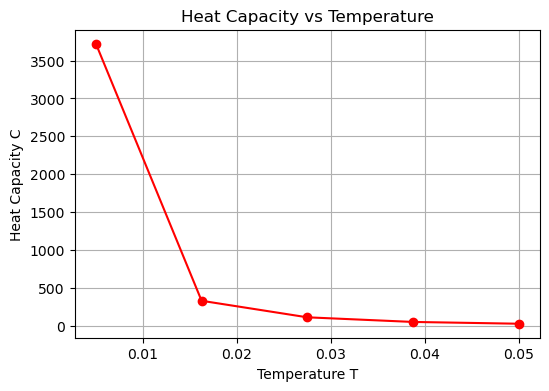

In [11]:
J=1
Nx=5
Ny=5
theta=2*np.pi/3
a=1

temperatures = np.linspace(0.005, 0.05, 5)  # temperature range
N_mc = 1000  # Monte Carlo steps for averaging

heat_capacity = []

for T in temperatures:
    # Initialize lattice
    lattice = Configuration(a, theta, Nx, Ny, J, T)
    
    energies = []
    
    for step in range(N_mc):
        lattice.Monte_Carlo(Nf=Nx*Ny*3)  # one MC step per spin
        energies.append(lattice.total_energy())
    
    energies = np.array(energies)
    C = (np.mean(energies**2) - np.mean(energies)**2) / T**2
    heat_capacity.append(C/(3*Nx*Ny))

# Plot
plt.figure(figsize=(6,4))
plt.plot(temperatures, heat_capacity, 'o-', color='red')
plt.xlabel('Temperature T')
plt.ylabel('Heat Capacity C')
plt.title('Heat Capacity vs Temperature')
plt.grid(True)
plt.show()



# Create a spin configuration
config = Configuration(a, theta, Nx, Ny, J, T)

# Optionally, perform some Monte Carlo steps to evolve spins
config.Monte_Carlo(Nf=1000)

# Display the spin configuration
config.display_config()